# Can we represent spectral lines with sparse tensors in PyTorch?

April 23, 2021  
gully

In [1]:
import torch

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Make a tensor composed of $N_{lines}$ sparsely spaced spectral lines.

In [2]:
N_lines = 50

We will adopt units of "deciAngstrom", equal to one tenth of an Angstrom.  This choice will help us stick to using integers, which is needed for the sparse index approach.

In [3]:
lam_lo = 105000
lam_hi = 110000
Delta_lam = lam_hi - lam_lo

In [4]:
wingcut = 100

In [5]:
lam_vec = torch.arange(lam_lo-wingcut, lam_hi+wingcut, step=1)

Draw $N_{lines}$ random wavelength centers $\lambda_c$, amplitudes $A$, and widths $w$ to simulate authentic spectral lines.

In [6]:
lam_centers_native = torch.randint(lam_lo, lam_hi, (N_lines,))
amplitudes = 0.01 + 0.3*torch.rand(N_lines)
widths = 4.1*torch.ones_like(amplitudes)

Stack the patches into a tensor and offset them by the line center position.

In [7]:
lambda_patch_native = torch.arange(-wingcut, wingcut,1).unsqueeze(1)
lambda_patches_native = torch.repeat_interleave(lambda_patch_native, N_lines, dim=1)
lambda_segments_native = lambda_patches_native + lam_centers_native

In [8]:
absorption_per_line = amplitudes*torch.exp(-0.5*lambda_patches_native**2/widths**2)

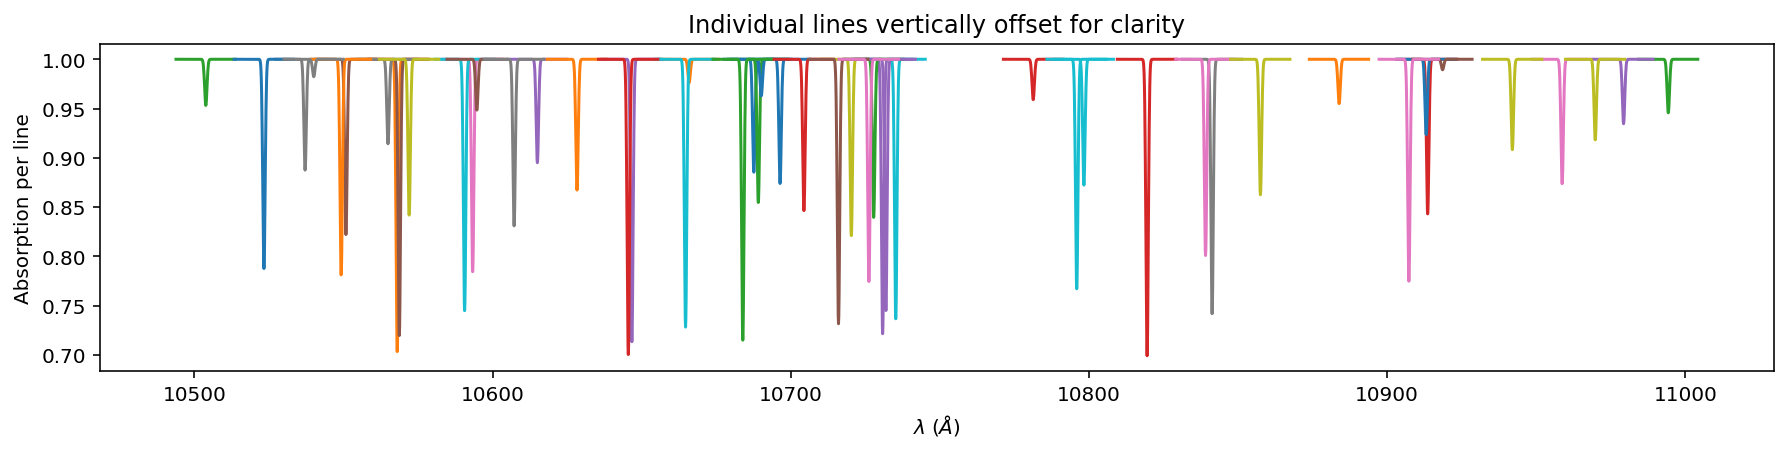

In [9]:
plt.figure(figsize=(15, 3))
plt.plot(lambda_segments_native/10, 1-absorption_per_line);
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Absorption per line')
plt.title('Individual lines vertically offset for clarity');

The lines sum together to make the net spectrum. To sum the spectrum we need to make a sparse tensor!

In [10]:
indices = lambda_segments_native - (lam_lo - wingcut)

Flatten the 2D Matrix into a 1D Vector.

In [11]:
indices_flat = indices.reshape(-1).unsqueeze(0)
values_flat = absorption_per_line.reshape(-1)

s = torch.sparse_coo_tensor(indices_flat, values_flat, (Delta_lam+wingcut*2,))

Now coalesce the spectrum, which sums the values at repeated indices.

In [12]:
summed = s.coalesce()
summed_vec = summed.to_dense()

In [13]:
lam_vec.shape, summed_vec.shape

(torch.Size([5200]), torch.Size([5200]))

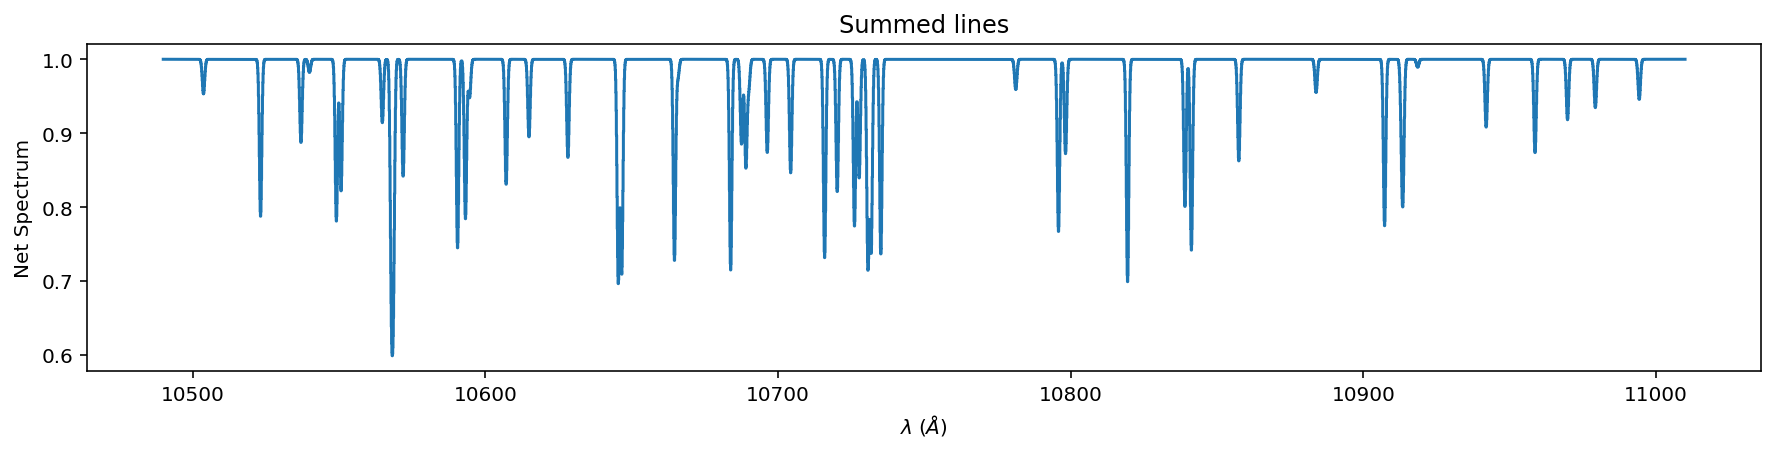

In [14]:
plt.figure(figsize=(15, 3))
plt.step(lam_vec/10, 1- summed_vec);
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Net Spectrum')
plt.title('Summed lines');

The summed spectrum appears as we'd expect---overlapping spectral lines form an amalgamation of features, only some of which resemble clean, isolated Gaussians.

### Issues and next steps: inability to infer Radial Velocity

The problem with sparse tensors is that they lose the memory of the line center positions because we are using integer indices which do not support gradients.  That means we cannot infer the radial velocity through backpropagation.  The barrier occurs at this line:

```python
lambda_segments_native = lambda_patches_native + lam_centers_native
```

Since the wavelength center positions have been truncated, one cannot easily "sense" the infintesimal changes to the spectrum that occur for a change in radial velocity.

The only reason this line of code works now is that the `lam_centers_native` is an integer, if we attempt to add a small RV offset, we lose the ability to use sparse tensors:

In [15]:
lambda_segments_native[0:3, 0:3]

tensor([[106864, 106559, 104938],
        [106865, 106560, 104939],
        [106866, 106561, 104940]])

In [16]:
delta_RV = 0.0123 # small change
lambda_segments_native = lambda_patches_native + lam_centers_native - delta_RV

In [17]:
lambda_segments_native[0:3, 0:3]

tensor([[106863.9844, 106558.9844, 104937.9844],
        [106864.9844, 106559.9844, 104938.9844],
        [106865.9844, 106560.9844, 104939.9844]])

Our next step will be to populate the dense array from the beginning which is extremely demanding on RAM and may be infeasible depending on the number of spectral lines $N_{lines}$.